## 2. Read the data file given and describe the data using pySpark

In [4]:
# Install PySpark (if not installed already)
!pip install pyspark

In [5]:
# Import the SparkSession module from PySpark
from pyspark.sql import SparkSession

In [35]:
# Initialize Spark Session
spark = SparkSession.builder.appName("Traffic Volume Analysis").getOrCreate()

In [9]:
# Load Dataset
df_raw = spark.read.format("csv")\
    .option("header", "true")\
    .option("inferSchema", "true")\
    .load("/Users/madhushan/DataEngineering/data/Metro_Interstate_Traffic_Volume.csv")\
    .coalesce(5)

In [11]:
# Cache the DataFrame
df_raw.cache()

DataFrame[holiday: string, temp: double, rain_1h: double, snow_1h: double, clouds_all: int, weather_main: string, weather_description: string, date_time: timestamp, traffic_volume: int]

In [12]:
# Create a Temporary SQL Table
df_raw.createOrReplaceTempView("dfTable")

In [16]:
# Preview the Data
print("First 5 rows of the dataset:")
df_raw.show(5)

First 5 rows of the dataset:
+-------+------+-------+-------+----------+------------+-------------------+-------------------+--------------+
|holiday|  temp|rain_1h|snow_1h|clouds_all|weather_main|weather_description|          date_time|traffic_volume|
+-------+------+-------+-------+----------+------------+-------------------+-------------------+--------------+
|   None|288.28|    0.0|    0.0|        40|      Clouds|   scattered clouds|2012-10-02 09:00:00|          5545|
|   None|289.36|    0.0|    0.0|        75|      Clouds|      broken clouds|2012-10-02 10:00:00|          4516|
|   None|289.58|    0.0|    0.0|        90|      Clouds|    overcast clouds|2012-10-02 11:00:00|          4767|
|   None|290.13|    0.0|    0.0|        90|      Clouds|    overcast clouds|2012-10-02 12:00:00|          5026|
|   None|291.14|    0.0|    0.0|        75|      Clouds|      broken clouds|2012-10-02 13:00:00|          4918|
+-------+------+-------+-------+----------+------------+-------------------

In [37]:
# Count total rows and columns
print(f"Total number of rows: {df_raw.count()}")
print(f"Total number of columns: {len(df_raw.columns)}")

Total number of rows: 48204
Total number of columns: 9


In [39]:
# Calculate MIN and MAX Dates
from pyspark.sql.functions import min, max

print("Date Range Analysis:")
date_range = df_raw.select(min("date_time").alias("Min Date"), max("date_time").alias("Max Date"))
date_range.show()

Date Range Analysis:
+-------------------+-------------------+
|           Min Date|           Max Date|
+-------------------+-------------------+
|2012-10-02 09:00:00|2018-09-30 23:00:00|
+-------------------+-------------------+



In [41]:
from pyspark.sql.types import StringType, IntegerType, DoubleType, FloatType

# Separate Categorical and Numerical Columns
categorical_columns = [field.name for field in df_raw.schema.fields if isinstance(field.dataType, StringType)]
numerical_columns = [field.name for field in df_raw.schema.fields if isinstance(field.dataType, (IntegerType, DoubleType, FloatType))]

# Display Categorical and Numerical Columns
print(f"Categorical columns: {categorical_columns}")
print(f"Numerical columns: {numerical_columns}")

Categorical columns: ['holiday', 'weather_main', 'weather_description']
Numerical columns: ['temp', 'rain_1h', 'snow_1h', 'clouds_all', 'traffic_volume']


In [43]:
# Frequency Analysis for Categorical Columns
print("Frequency Analysis for Categorical Columns:\n")
for column in categorical_columns:
    print(f"Frequency Analysis for {column}:")
    df_raw.groupBy(column).count().orderBy('count', ascending=False).show(50)

Frequency Analysis for Categorical Columns:

Frequency Analysis for holiday:
+--------------------+-----+
|             holiday|count|
+--------------------+-----+
|                none|48143|
|           labor day|    7|
|martin luther kin...|    6|
|       new years day|    6|
|    thanksgiving day|    6|
|       christmas day|    6|
|        columbus day|    5|
|washingtons birthday|    5|
|        memorial day|    5|
|          state fair|    5|
|        veterans day|    5|
|    independence day|    5|
+--------------------+-----+

Frequency Analysis for weather_main:
+------------+-----+
|weather_main|count|
+------------+-----+
|      clouds|15164|
|       clear|13391|
|        mist| 5950|
|        rain| 5672|
|        snow| 2876|
|     drizzle| 1821|
|        haze| 1360|
|thunderstorm| 1034|
|         fog|  912|
|       smoke|   20|
|      squall|    4|
+------------+-----+

Frequency Analysis for weather_description:
+--------------------+-----+
| weather_description|count|
+--

In [45]:
# There are two different category for "sky is clear" and "Sky is Clear". Need to convert all categories into lower case for this.

In [47]:
from pyspark.sql.functions import col, lower

# Convert all values in categorical columns to lowercase
for column in categorical_columns:
    df_raw = df_raw.withColumn(column, lower(col(column)))

print("Frequency Analysis for Categorical Columns (after normalization):\n")
for column in categorical_columns:
    print(f"Frequency Analysis for {column}:")
    df_raw.groupBy(column).count().orderBy('count', ascending=False).show(50)

Frequency Analysis for Categorical Columns (after normalization):

Frequency Analysis for holiday:
+--------------------+-----+
|             holiday|count|
+--------------------+-----+
|                none|48143|
|           labor day|    7|
|martin luther kin...|    6|
|       new years day|    6|
|    thanksgiving day|    6|
|       christmas day|    6|
|        columbus day|    5|
|washingtons birthday|    5|
|        memorial day|    5|
|          state fair|    5|
|        veterans day|    5|
|    independence day|    5|
+--------------------+-----+

Frequency Analysis for weather_main:
+------------+-----+
|weather_main|count|
+------------+-----+
|      clouds|15164|
|       clear|13391|
|        mist| 5950|
|        rain| 5672|
|        snow| 2876|
|     drizzle| 1821|
|        haze| 1360|
|thunderstorm| 1034|
|         fog|  912|
|       smoke|   20|
|      squall|    4|
+------------+-----+

Frequency Analysis for weather_description:
+--------------------+-----+
| weather_

In [49]:
# Statistical Analysis for Numeric columns
print("Statistical Analysis for Numeric Columns:")
df_raw.describe(numerical_columns).show()

Statistical Analysis for Numeric Columns:
+-------+------------------+-------------------+--------------------+-----------------+------------------+
|summary|              temp|            rain_1h|             snow_1h|       clouds_all|    traffic_volume|
+-------+------------------+-------------------+--------------------+-----------------+------------------+
|  count|             48204|              48204|               48204|            48204|             48204|
|   mean| 281.2058703012135|0.33426396149697535|2.223881835532321...|49.36223135009543|3259.8183553232097|
| stddev|13.338231912676308|  44.78913303693933|0.008167611205361601|39.01575046141368|1986.8606704463612|
|    min|               0.0|                0.0|                 0.0|                0|                 0|
|    max|            310.07|             9831.3|                0.51|              100|              7280|
+-------+------------------+-------------------+--------------------+-----------------+---------------

## 3. Produce a meta-data table to show the characteristics of each attribute and explain

In [52]:
# Display the Schema
print("Schema of the dataset:")
df_raw.printSchema()

Schema of the dataset:
root
 |-- holiday: string (nullable = true)
 |-- temp: double (nullable = true)
 |-- rain_1h: double (nullable = true)
 |-- snow_1h: double (nullable = true)
 |-- clouds_all: integer (nullable = true)
 |-- weather_main: string (nullable = true)
 |-- weather_description: string (nullable = true)
 |-- date_time: timestamp (nullable = true)
 |-- traffic_volume: integer (nullable = true)



In [54]:
from pyspark.sql.functions import col, countDistinct

meta_data = []
for field in df_raw.schema.fields:
    null_count = df_raw.filter(df_raw[field.name].isNull()).count()
    is_categorical = isinstance(field.dataType, StringType)
    meta_data.append((field.name, str(field.dataType), null_count, is_categorical))

# Convert to PySpark DataFrame
meta_data_df = spark.createDataFrame(meta_data, ["Column Name", "Data Type", "Missing Values",  "Is Categorical"])
print("Meta-Data Table:")
meta_data_df.show()

Meta-Data Table:
+-------------------+---------------+--------------+--------------+
|        Column Name|      Data Type|Missing Values|Is Categorical|
+-------------------+---------------+--------------+--------------+
|            holiday|   StringType()|             0|          true|
|               temp|   DoubleType()|             0|         false|
|            rain_1h|   DoubleType()|             0|         false|
|            snow_1h|   DoubleType()|             0|         false|
|         clouds_all|  IntegerType()|             0|         false|
|       weather_main|   StringType()|             0|          true|
|weather_description|   StringType()|             0|          true|
|          date_time|TimestampType()|             0|         false|
|     traffic_volume|  IntegerType()|             0|         false|
+-------------------+---------------+--------------+--------------+



In [55]:
#Import necessary libraries for plot
import matplotlib.pyplot as plt
import seaborn as sns

In [57]:
# Convert PySpark DataFrame to Pandas for visualization
traffic_data_pd = df_raw.toPandas()

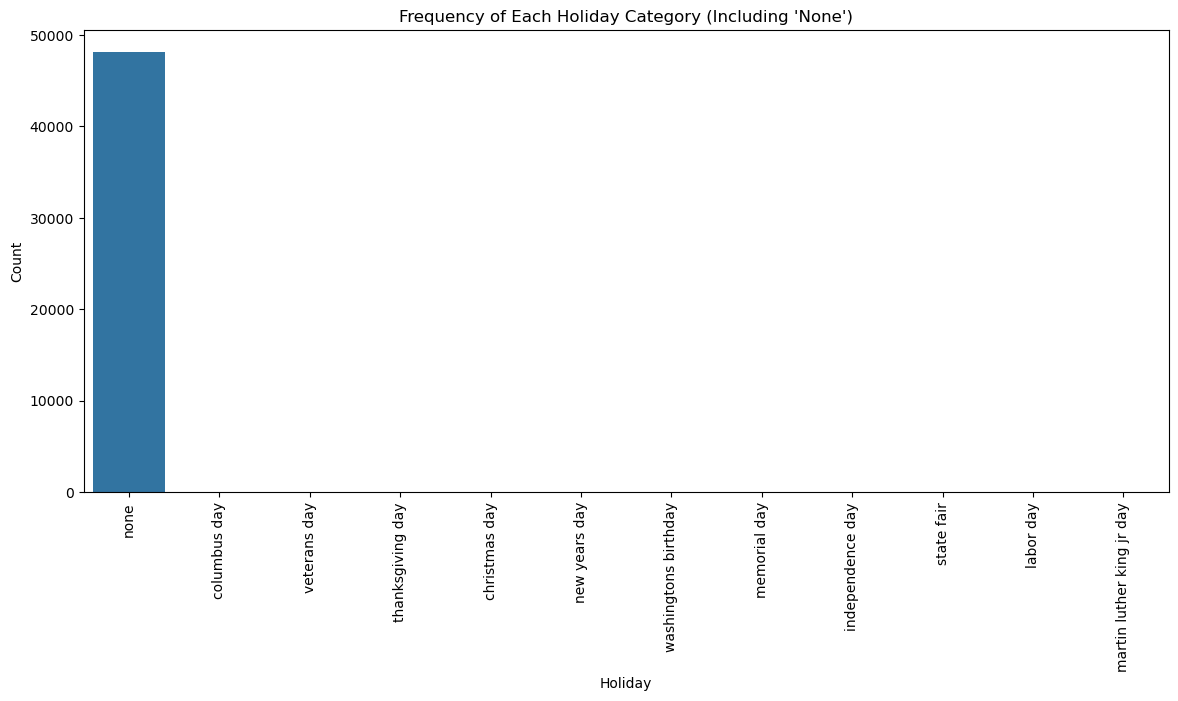

In [58]:
# Frequency of each category in the 'holiday' column
plt.figure(figsize=(14, 6))
sns.countplot(x='holiday', data=traffic_data_pd)
plt.title("Frequency of Each Holiday Category (Including 'None')")
plt.xlabel("Holiday")
plt.xticks(rotation=90)
plt.ylabel("Count")
plt.show()

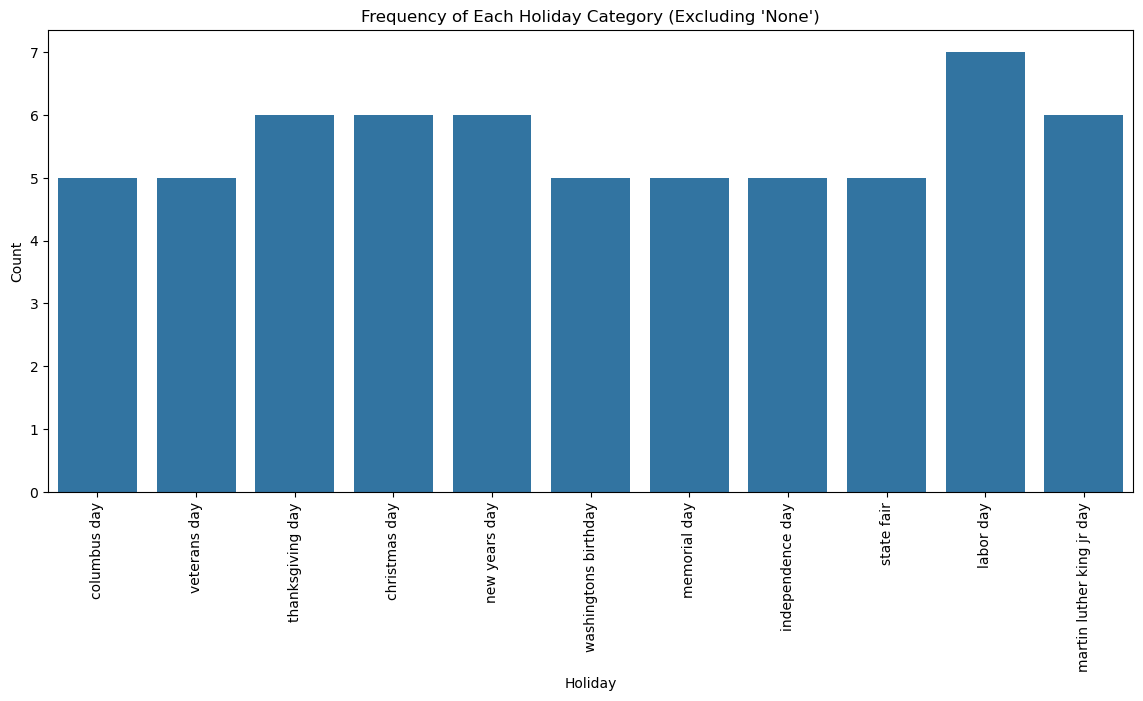

In [59]:
# The category 'None' is overwhelmingly dominant, which makes it hard to observe other holidays.

# Filter out rows where 'holiday' is 'None'
holidays = traffic_data_pd[traffic_data_pd['holiday'] != 'none']

# Frequency of each holiday category (excluding 'None')
plt.figure(figsize=(14, 6))
sns.countplot(x='holiday', data=holidays)
plt.title("Frequency of Each Holiday Category (Excluding 'None')")
plt.xlabel("Holiday")
plt.xticks(rotation=90)
plt.ylabel("Count")
plt.show()

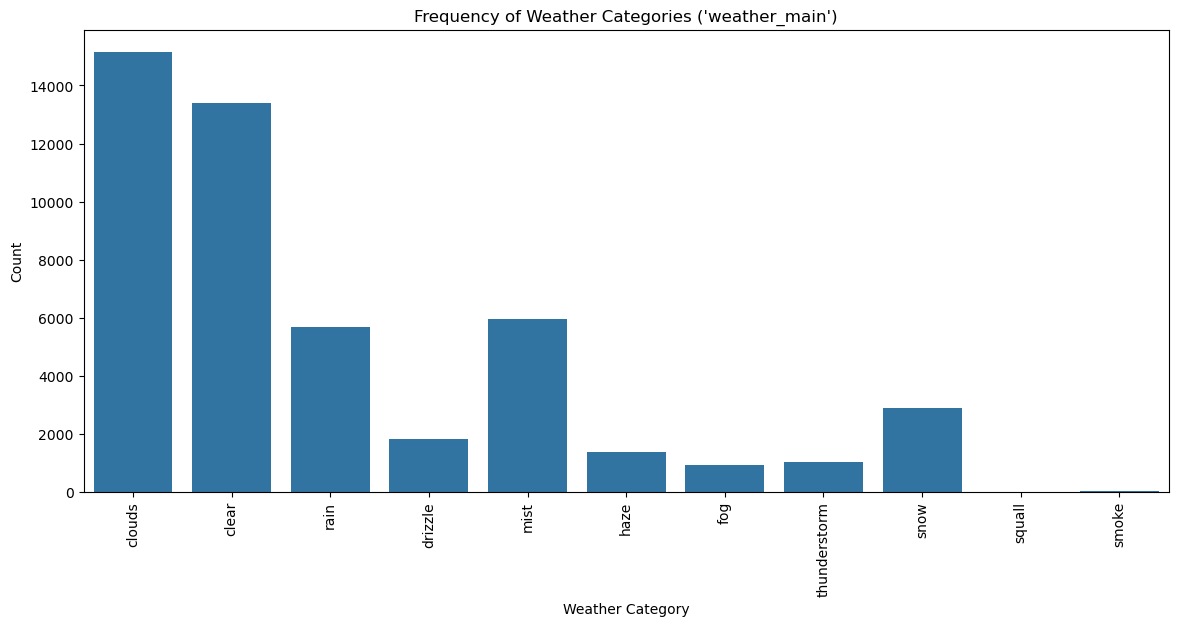

In [61]:
# Plot the frequency of each category in the 'weather_main' column
plt.figure(figsize=(14, 6))
sns.countplot(x='weather_main', data=traffic_data_pd)
plt.title("Frequency of Weather Categories ('weather_main')")
plt.xlabel("Weather Category")
plt.xticks(rotation=90)
plt.ylabel("Count")
plt.show()

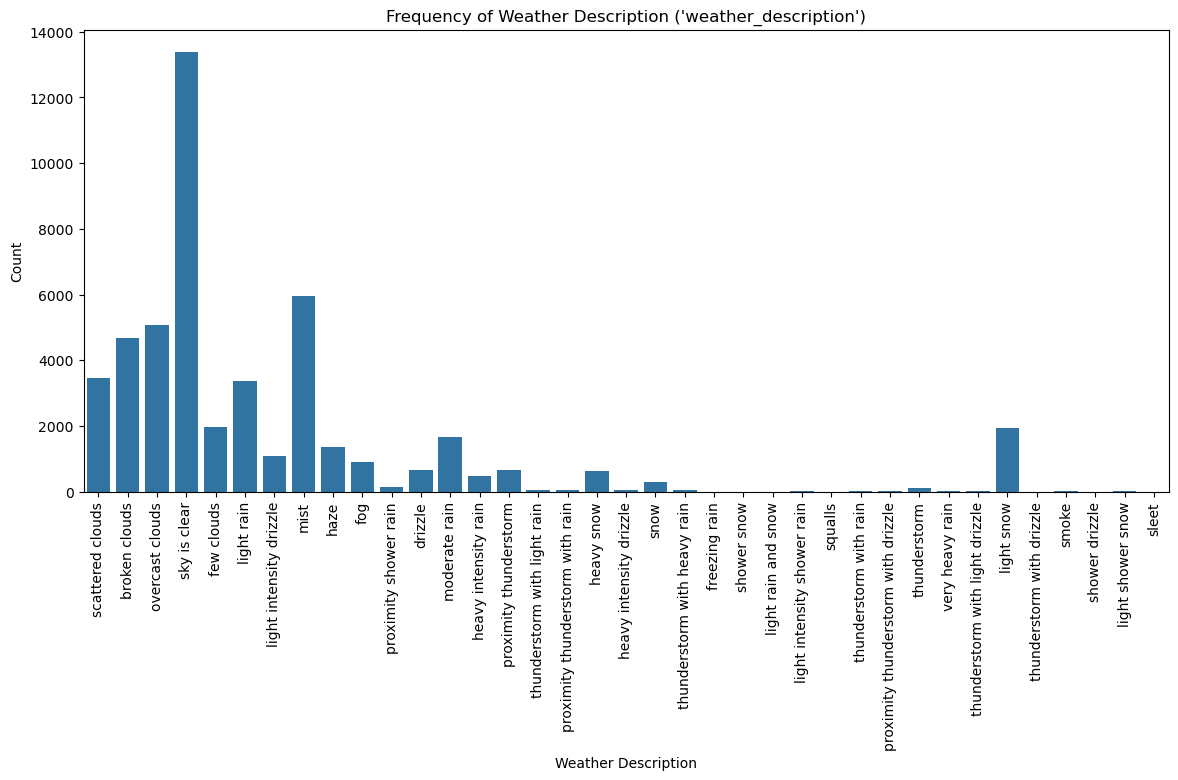

In [62]:
# Plot the frequency of each category in the 'weather_description' column
plt.figure(figsize=(14, 6))
sns.countplot(x='weather_description', data=traffic_data_pd)
plt.title("Frequency of Weather Description ('weather_description')")
plt.xlabel("Weather Description")
plt.xticks(rotation=90)
plt.ylabel("Count")
plt.show()

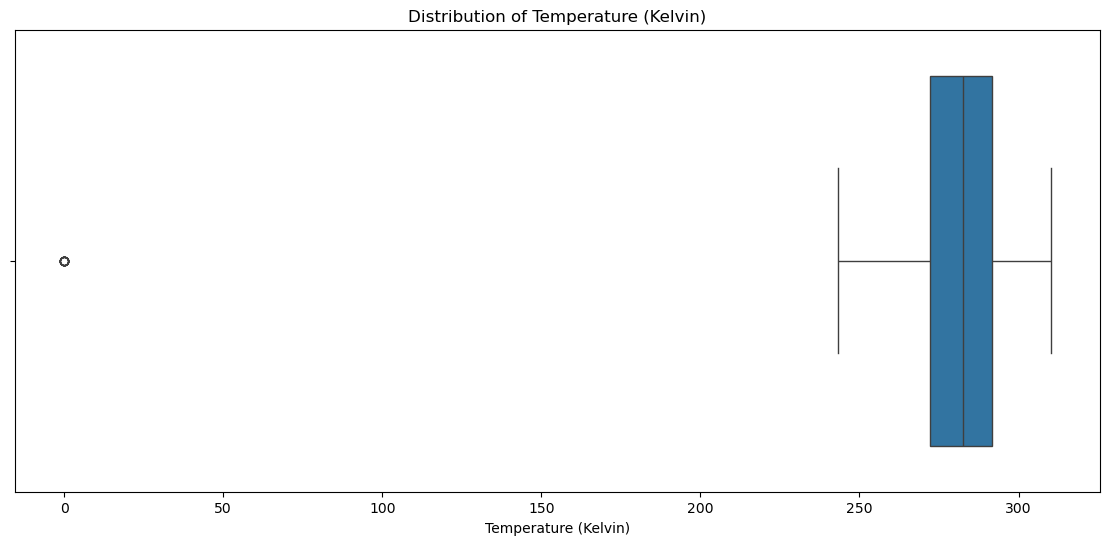

In [63]:
# Plotting the distribution of the temperature variable using a boxplot

# Plot the boxplot for temperature in Kelvin
plt.figure(figsize=(14, 6))
sns.boxplot(x='temp', data=traffic_data_pd)
plt.title("Distribution of Temperature (Kelvin)")
plt.xlabel("Temperature (Kelvin)")
plt.show()

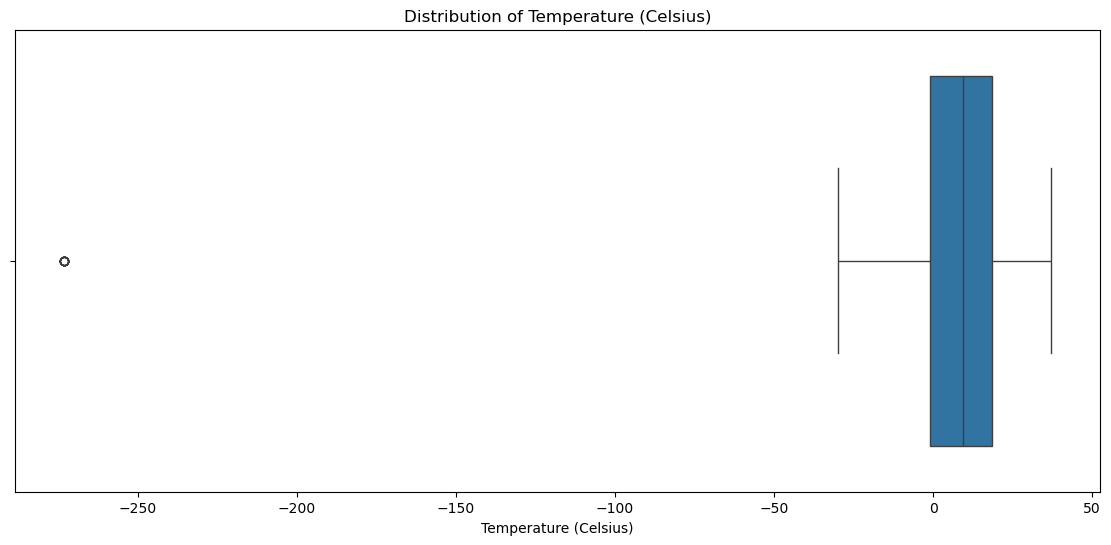

In [64]:
#Converting from Kelvin to Celsius makes the data easier to interpret and analyze since Celsius is more commonly used in weather analysis.
traffic_data_pd['temp_celsius'] = traffic_data_pd['temp'] - 273.15

# Plot the boxplot for temperature in Celsius
plt.figure(figsize=(14, 6))
sns.boxplot(x='temp_celsius', data=traffic_data_pd)
plt.title("Distribution of Temperature (Celsius)")
plt.xlabel("Temperature (Celsius)")
plt.show()

In [65]:
# Comment: There is a significant outlier in the `temp` variable, with a value of 0 Kelvin (-273.15°C), 
# which is physically impossible for Average temp in kelvin. This indicates a data recording error.

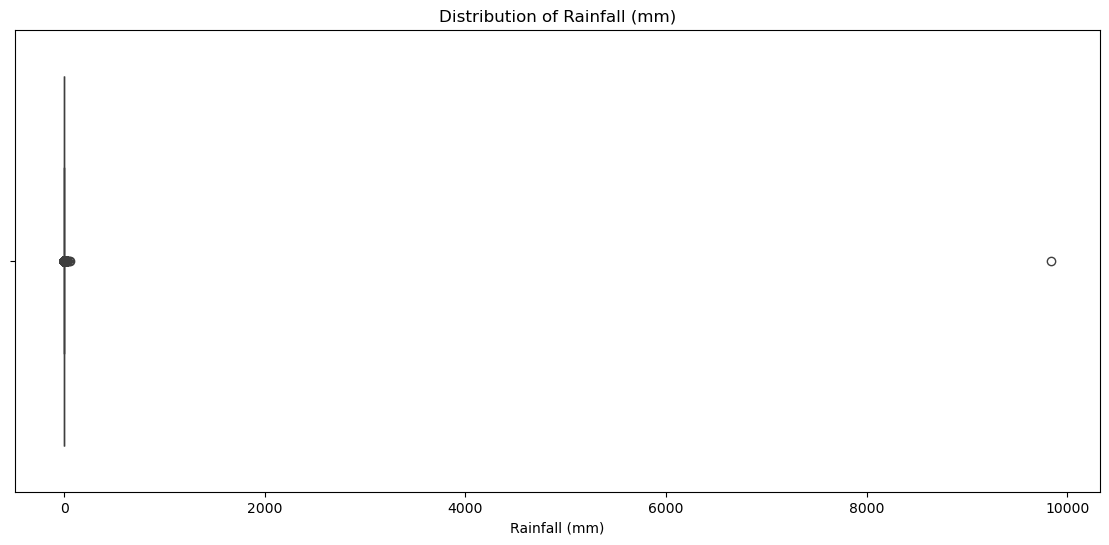

In [67]:
# Boxplot for rain variable
plt.figure(figsize=(14, 6))
sns.boxplot(x='rain_1h', data=traffic_data_pd)
plt.title("Distribution of Rainfall (mm)")
plt.xlabel("Rainfall (mm)")
plt.show()

In [69]:
# Comment: There is a significant outlier in the `rain_1h` variable, with a value close to 10,000 mm, 
# which is physically impossible for hourly rainfall. This indicates a data recording error.

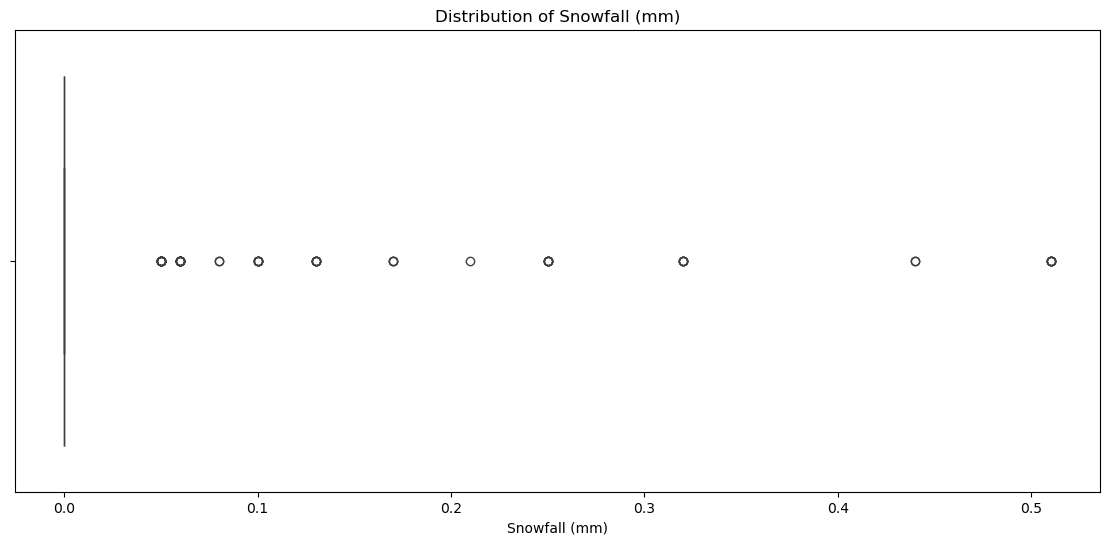

In [72]:
# Boxplot for snow variable
plt.figure(figsize=(14, 6))
sns.boxplot(x='snow_1h', data=traffic_data_pd)
plt.title("Distribution of Snowfall (mm)")
plt.xlabel("Snowfall (mm)")
plt.show()

In [73]:
# There are no extreme or unrealistic outliers in the dataset. All values seem plausible for snowfall.

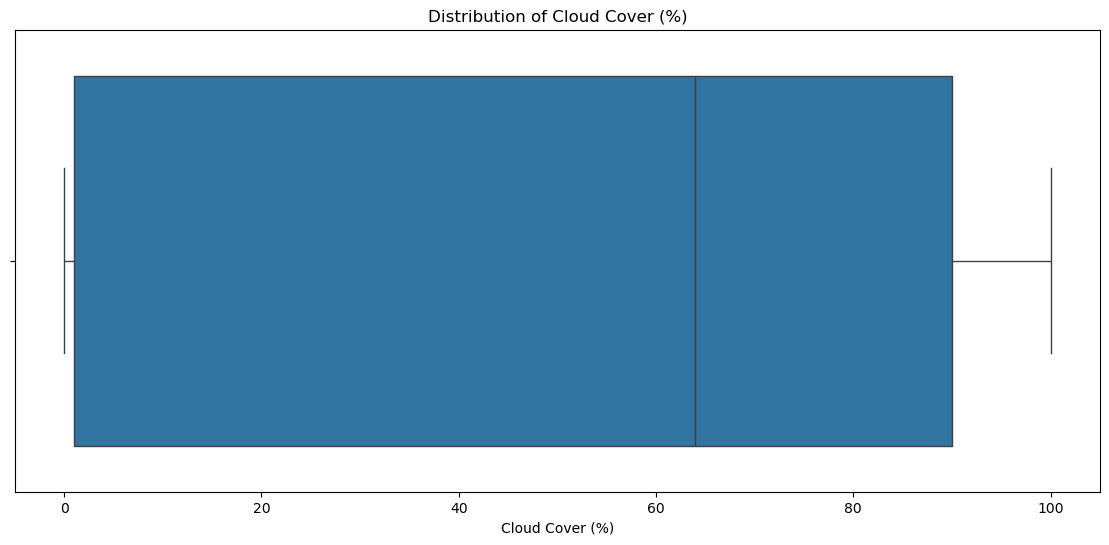

In [78]:
# Boxplot for clouds_all variable
plt.figure(figsize=(14, 6))
sns.boxplot(x='clouds_all', data=traffic_data_pd)
plt.title("Distribution of Cloud Cover (%)")
plt.xlabel("Cloud Cover (%)")
plt.show()

In [83]:
# No values exceed 100% or fall below 0%, there are no points outside the expected range.

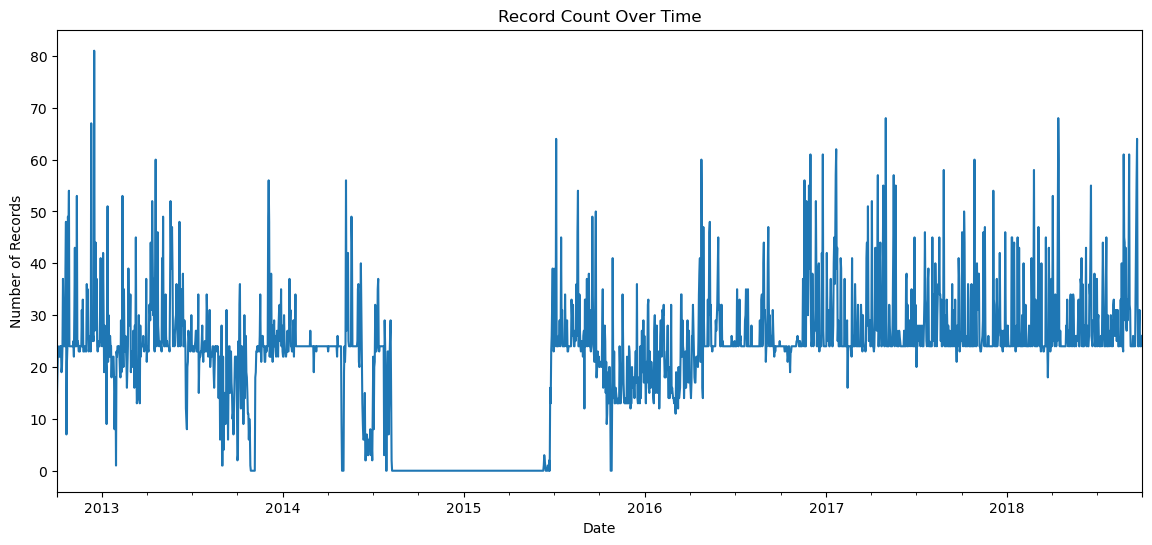

In [86]:
# Resample data to count records per day
record_count = traffic_data_pd.set_index('date_time').resample('D').size()

# Plot record count over time
plt.figure(figsize=(14, 6))
record_count.plot()
plt.title("Record Count Over Time")
plt.xlabel("Date")
plt.ylabel("Number of Records")
plt.show()

In [88]:
import pandas as pd

# Ensure date_time is in datetime format
traffic_data_pd['date_time'] = pd.to_datetime(traffic_data_pd['date_time'])

# Sort the dataset by date_time
traffic_data_pd = traffic_data_pd.sort_values(by='date_time')

traffic_data_pd['time_diff'] = traffic_data_pd['date_time'].diff()
gap_threshold = pd.Timedelta(days=1)
gaps = traffic_data_pd[traffic_data_pd['time_diff'] > gap_threshold]

# Extract relevant gap details
gap_details = pd.DataFrame({ 
    'Start of Gap': gaps['date_time'] - gaps['time_diff'], 
    'End of Gap': gaps['date_time'], 
    'Gap Duration (days)': gaps['time_diff'].dt.days}).reset_index(drop=True)

# Display the gap details
print("Gap Details in Data:")
display(gap_details)

Gap Details in Data:


,Start of Gap,End of Gap,Gap Duration (days)
0,2013-01-29 00:00:00,2013-01-30 01:00:00,1
1,2013-08-31 00:00:00,2013-09-01 23:00:00,1
2,2013-09-03 02:00:00,2013-09-04 08:00:00,1
3,2013-10-27 01:00:00,2013-11-06 04:00:00,10
4,2014-04-29 08:00:00,2014-05-04 05:00:00,4
5,2014-07-27 16:00:00,2014-07-30 09:00:00,2
6,2014-08-02 02:00:00,2014-08-03 11:00:00,1
7,2014-08-08 01:00:00,2015-06-11 20:00:00,307
8,2015-06-14 20:00:00,2015-06-19 18:00:00,4
9,2015-06-20 18:00:00,2015-06-22 00:00:00,1


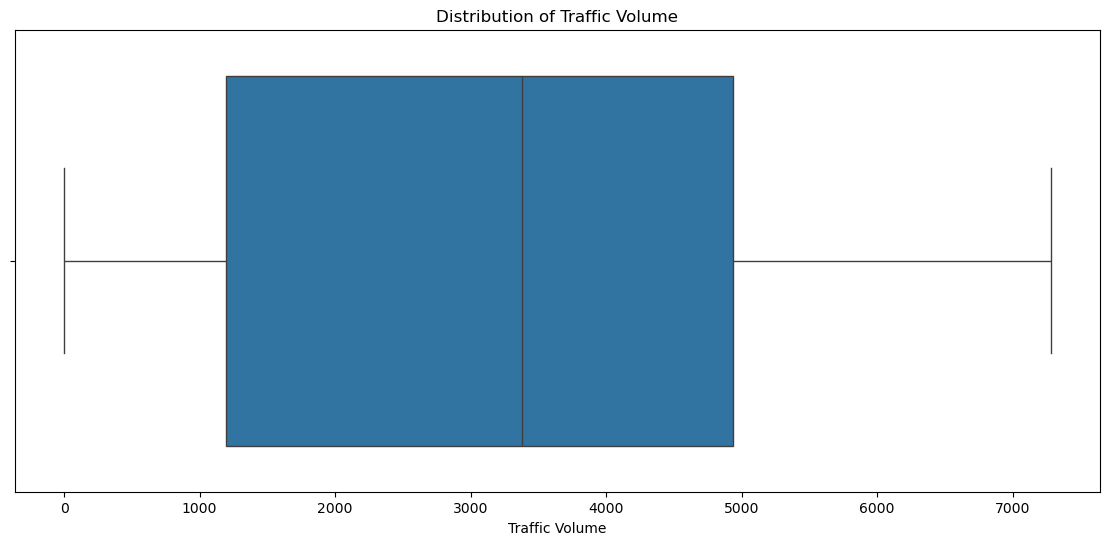

In [90]:
# Boxplot for traffic_volume variable
plt.figure(figsize=(14, 6))
sns.boxplot(x='traffic_volume', data=traffic_data_pd)
plt.title("Distribution of Traffic Volume")
plt.xlabel("Traffic Volume")
plt.show()

## 4.	Transform required variables from categorical to ordinal/numerical data using PySpark libraries

In [93]:
from pyspark.ml.feature import StringIndexer

In [95]:
# Transforming categorical variables into numerical (ordinal) format using StringIndexer
df_transformed = df_raw

for col in categorical_columns:
    indexer = StringIndexer(inputCol=col, outputCol=f"{col}_indexed")
    df_transformed = indexer.fit(df_transformed).transform(df_transformed)

In [96]:
# Show the transformed dataset with indexed columns
df_transformed.select("holiday", "holiday_indexed", "weather_main", "weather_main_indexed" , 
                      "weather_description", "weather_description_indexed").show(10)

+-------+---------------+------------+--------------------+-------------------+---------------------------+
|holiday|holiday_indexed|weather_main|weather_main_indexed|weather_description|weather_description_indexed|
+-------+---------------+------------+--------------------+-------------------+---------------------------+
|   none|            0.0|      clouds|                 0.0|   scattered clouds|                        4.0|
|   none|            0.0|      clouds|                 0.0|      broken clouds|                        3.0|
|   none|            0.0|      clouds|                 0.0|    overcast clouds|                        2.0|
|   none|            0.0|      clouds|                 0.0|    overcast clouds|                        2.0|
|   none|            0.0|      clouds|                 0.0|      broken clouds|                        3.0|
|   none|            0.0|       clear|                 1.0|       sky is clear|                        0.0|
|   none|            0.0|   

In [99]:
# Displaying distinct values and their indexed representation for 'holiday' 'weather_main' and 'weather_description'
print("Category and Indexed Values for 'holiday':")
df_transformed.select("holiday", "holiday_indexed").distinct().orderBy("holiday_indexed").show()

print("Category and Indexed Values for 'weather_main':")
df_transformed.select("weather_main", "weather_main_indexed").distinct().orderBy("weather_main_indexed").show()

print("Category and Indexed Values for 'weather_description':")
df_transformed.select("weather_description", "weather_description_indexed").distinct().orderBy("weather_description_indexed").show(50)

Category and Indexed Values for 'holiday':
+--------------------+---------------+
|             holiday|holiday_indexed|
+--------------------+---------------+
|                none|            0.0|
|           labor day|            1.0|
|       christmas day|            2.0|
|martin luther kin...|            3.0|
|       new years day|            4.0|
|    thanksgiving day|            5.0|
|        columbus day|            6.0|
|    independence day|            7.0|
|        memorial day|            8.0|
|          state fair|            9.0|
|        veterans day|           10.0|
|washingtons birthday|           11.0|
+--------------------+---------------+

Category and Indexed Values for 'weather_main':
+------------+--------------------+
|weather_main|weather_main_indexed|
+------------+--------------------+
|      clouds|                 0.0|
|       clear|                 1.0|
|        mist|                 2.0|
|        rain|                 3.0|
|        snow|                 4

## 5. Create a new Dataframe with reduced, clean and sorted data

In [102]:
from pyspark.sql.functions import year, month, dayofmonth, hour, col

In [104]:
# Remove duplicates from the original dataset
no_duplicates_data = df_transformed.distinct()

In [106]:
# Select relevant columns
selected_columns = [
    "holiday_indexed",
    "temp",
    "rain_1h",
    "snow_1h",
    "clouds_all",
    "weather_main_indexed",
    "weather_description_indexed",
    "date_time",
    "traffic_volume"
]
reduced_data = no_duplicates_data.select(selected_columns)

In [108]:
# Remove outliers
cleaned_data = reduced_data.filter(
    (col("temp") > 0) &  # Remove invalid temperature (0 Kelvin)
    (col("rain_1h") <= 100) &  # Remove rainfall outliers (>100 mm)
    (col("rain_1h") >= 0) &  # Ensure rainfall is non-negative
    (col("snow_1h") >= 0) &  # Ensure snowfall is non-negative
    (col("clouds_all") >= 0) & (col("clouds_all") <= 100)  # Ensure cloud cover is valid
)

In [110]:
# Sort the data by `date_time`
df_formatted = cleaned_data.orderBy("date_time")

In [112]:
# Show the cleaned, reduced, and sorted DataFrame
df_formatted.show(10)

+---------------+------+-------+-------+----------+--------------------+---------------------------+-------------------+--------------+
|holiday_indexed|  temp|rain_1h|snow_1h|clouds_all|weather_main_indexed|weather_description_indexed|          date_time|traffic_volume|
+---------------+------+-------+-------+----------+--------------------+---------------------------+-------------------+--------------+
|            0.0|288.28|    0.0|    0.0|        40|                 0.0|                        4.0|2012-10-02 09:00:00|          5545|
|            0.0|289.36|    0.0|    0.0|        75|                 0.0|                        3.0|2012-10-02 10:00:00|          4516|
|            0.0|289.58|    0.0|    0.0|        90|                 0.0|                        2.0|2012-10-02 11:00:00|          4767|
|            0.0|290.13|    0.0|    0.0|        90|                 0.0|                        2.0|2012-10-02 12:00:00|          5026|
|            0.0|291.14|    0.0|    0.0|        

In [113]:
# Show the cleaned, reduced, and sorted DataFram total count
print(f"Total formatted number of rows: {df_formatted.count()}")

Total formatted number of rows: 48176


## 6. Write a PySpark programme to show summary statistics of variables – sum, mean, standard deviation, skewness and kurtosis in variables

In [117]:
from pyspark.sql.functions import mean, sum as _sum, stddev, skewness, kurtosis, lit

In [119]:
# Create a dictionary to store summary statistics for each column
summary_statistics = {}

# Compute summary statistics for each numerical column
for col_name in numerical_columns:
    stats = df_formatted.select(
        _sum(col_name).alias("Sum"),
        mean(col_name).alias("Mean"),
        stddev(col_name).alias("Standard Deviation"),
        skewness(col_name).alias("Skewness"),
        kurtosis(col_name).alias("Kurtosis")
    ).first()

    # Store the results
    summary_statistics[col_name] = {
        "Sum": stats["Sum"],
        "Mean": stats["Mean"],
        "Standard Deviation": stats["Standard Deviation"],
        "Skewness": stats["Skewness"],
        "Kurtosis": stats["Kurtosis"]
    }

In [120]:
# Print the summary statistics for each column
print("Summary Statistics:")
for col, stats in summary_statistics.items():
    print(f"\nColumn: {col}")
    for metric, value in stats.items():
        print(f"{metric}: {value:.2f}")

Summary Statistics:

Column: temp
Sum: 13550122.96
Mean: 281.26
Standard Deviation: 12.71
Skewness: -0.36
Kurtosis: -0.66

Column: rain_1h
Sum: 6281.56
Mean: 0.13
Standard Deviation: 1.00
Skewness: 18.09
Kurtosis: 521.11

Column: snow_1h
Sum: 10.72
Mean: 0.00
Standard Deviation: 0.01
Skewness: 48.35
Kurtosis: 2618.67

Column: clouds_all
Sum: 2378698.00
Mean: 49.38
Standard Deviation: 39.01
Skewness: -0.20
Kurtosis: -1.74

Column: traffic_volume
Sum: 157052502.00
Mean: 3259.97
Standard Deviation: 1986.85
Skewness: -0.09
Kurtosis: -1.31


## 7. Write a PySpark program to calculate and show the correlation of each variable with the target variable. 

In [122]:
from pyspark.sql.functions import corr

In [123]:
# List of columns to compare with the target variable
correlation_columns = ['temp', 'rain_1h', 'snow_1h', 'clouds_all']

In [124]:
# Create a dictionary to store correlation results
correlation_results = {}

# Calculate correlation of each numerical variable with the target variable
for col_name in correlation_columns:
    correlation = df_formatted.stat.corr(col_name, "traffic_volume")
    correlation_results[col_name] = correlation

# Display correlation results
print("Correlation of variables with traffic_volume:")
for col_name, corr_value in correlation_results.items():
    print(f"  {col_name}: {corr_value}")

Correlation of variables with traffic_volume:
  temp: 0.13211453369302284
  rain_1h: -0.022372040946712315
  snow_1h: 0.0007315204471133284
  clouds_all: 0.06688865352103052


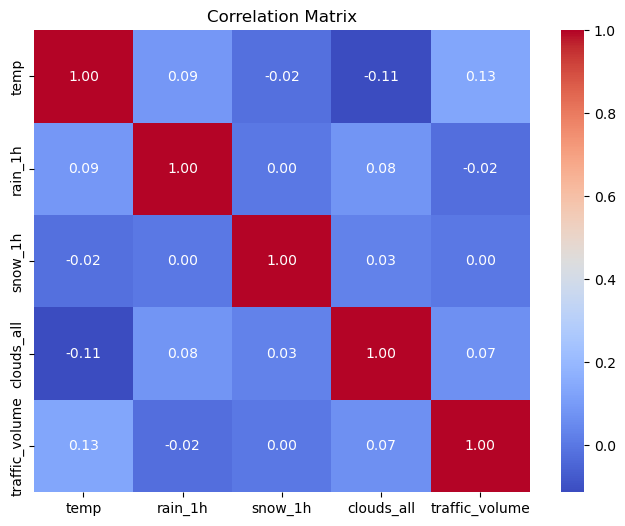

In [125]:
# Convert PySpark DataFrame to Pandas for visualization
numerical_data = df_formatted.select(numerical_columns).toPandas()

# Compute the correlation matrix
correlation_matrix = numerical_data.corr()

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

In [154]:
import pandas as pd

# Feature Engineering
df_traffic_features = df_formatted.toPandas()

#Extracting features from date_time variable
df_traffic_features['date_time'] = pd.to_datetime(df_traffic_features.date_time)
df_traffic_features['year'] = df_traffic_features.date_time.dt.year
df_traffic_features['month'] = df_traffic_features.date_time.dt.month
df_traffic_features['day'] = df_traffic_features.date_time.dt.day
df_traffic_features['weekday'] = df_traffic_features.date_time.dt.weekday
df_traffic_features['hour'] = df_traffic_features.date_time.dt.hour

df_traffic_features.head()

df_traffic_features.to_csv('output/output_data.csv',header=True,index=False)
print("Data exported successfully as 'output_data.csv'")

Data exported successfully as 'output_data.csv'


In [156]:
import json

df_pandas = df_formatted.toPandas()

# Convert `date_time` to datetime and extract components
df_pandas['date_time'] = pd.to_datetime(df_pandas['date_time'])
df_pandas['year'] = df_pandas['date_time'].dt.year
df_pandas['month'] = df_pandas['date_time'].dt.strftime('%B')  # Full month name (e.g., January)
df_pandas['day'] = df_pandas['date_time'].dt.strftime('%A')    # Full day name (e.g., Monday)

# Aggregate data
grouped = df_pandas.groupby(['year', 'month', 'day'])['traffic_volume'].sum().reset_index()

# Create hierarchical JSON
hierarchical_data = {"name": "Traffic Data", "children": []}

for year, year_group in grouped.groupby('year'):
    year_dict = {"name": str(year), "children": []}
    for month, month_group in year_group.groupby('month'):
        month_dict = {"name": month, "children": []}
        for day, day_group in month_group.groupby('day'):
            day_dict = {"name": day, "size": int(day_group['traffic_volume'].sum())}  # Sum traffic volume for each day
            month_dict["children"].append(day_dict)
        year_dict["children"].append(month_dict)
    hierarchical_data["children"].append(year_dict)

# Save to JSON
output_file = "output/hierarchical_traffic_data.json"
with open(output_file, "w") as f:
    json.dump(hierarchical_data, f, indent=4)

print(f"Hierarchical JSON saved to {output_file}")


Hierarchical JSON saved to output/hierarchical_traffic_data.json


## 10.	Build predictive models to predict the traffic volume for a week after the final date of the gathered data with pySpark form the given Dataset using MLlib. 

In [159]:
# Importing Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from datetime import datetime, timedelta

In [160]:
# Load Data
def load_data(file_path):
    data = pd.read_csv(file_path)
    print("Data Loaded Successfully")
    display(data.head())
    return data

In [163]:
# Preprocess and Split Data
def preprocess_and_split_data(data, drop_low_importance=True):
    features = ['holiday_indexed', 'temp', 'rain_1h', 'clouds_all',
                'weather_main_indexed', 'weather_description_indexed',
                'year', 'month', 'day', 'weekday', 'hour']
    target = 'traffic_volume'
    
    # Feature Engineering: Add Rush Hour
    data['rush_hour'] = data['hour'].apply(lambda x: 1 if (7 <= x <= 10 or 16 <= x <= 19) else 0)
    print("Added 'rush_hour' feature to the dataset.")

    # Add new feature to the feature list
    features.append('rush_hour')
    
    # Drop near-zero importance features (optional)
    if drop_low_importance:
        features = [col for col in features if col not in ['snow_1h', 'holiday_indexed']]
    
    X = data[features]
    y = data[target]
    
    # Train-test split
    xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.25, random_state=42)
    return X, xtrain, xtest, ytrain, ytest

In [165]:
# Train Decision Tree
def decision_tree(xtrain, xtest, ytrain, ytest):
    print("\nTraining Decision Tree...")
    DT = DecisionTreeRegressor()
    DT.fit(xtrain, ytrain)
    pred = DT.predict(xtest)
    default_metrics = evaluate_model(ytest, pred, "Decision Tree (Default)")
    
    # Grid Search
    param_grid = {'max_depth': np.arange(1, 15), 'min_samples_split': [2, 5, 10]}
    grid_search = GridSearchCV(DecisionTreeRegressor(), param_grid, cv=3)
    grid_search.fit(xtrain, ytrain)
    print("Best Parameters:", grid_search.best_params_)
    
    # Train with Best Parameters
    DT_best = DecisionTreeRegressor(**grid_search.best_params_)
    DT_best.fit(xtrain, ytrain)
    pred_best = DT_best.predict(xtest)
    tuned_metrics = evaluate_model(ytest, pred_best, "Decision Tree (Tuned)")
    return DT_best, default_metrics, tuned_metrics

In [167]:
# Train Random Forest
def random_forest(xtrain, xtest, ytrain, ytest):
    print("\nTraining Random Forest...")
    RF = RandomForestRegressor()
    RF.fit(xtrain, ytrain)
    pred = RF.predict(xtest)
    default_metrics = evaluate_model(ytest, pred, "Random Forest (Default)")
    
    # Grid Search
    param_grid = {'max_depth': np.arange(5, 15), 'n_estimators': np.arange(10, 50, 10)}
    grid_search = GridSearchCV(RandomForestRegressor(), param_grid, cv=3)
    grid_search.fit(xtrain, ytrain)
    print("Best Parameters:", grid_search.best_params_)
    
    # Train with Best Parameters
    RF_best = RandomForestRegressor(**grid_search.best_params_)
    RF_best.fit(xtrain, ytrain)
    pred_best = RF_best.predict(xtest)
    tuned_metrics = evaluate_model(ytest, pred_best, "Random Forest (Tuned)")
    return RF_best, default_metrics, tuned_metrics

In [217]:
# Single Prediction
def single_prediction(model, X, **kwargs):
    input_data = {col: 0 for col in X.columns}
    input_data.update(kwargs)
    input_df = pd.DataFrame([input_data], columns=X.columns)
    
    # Debugging: Print the input data
    print("Input Features for Prediction:")
    display(input_df)
    
    prediction = model.predict(input_df)[0]
    print(f"Predicted Traffic Volume: {int(round(prediction))}")

In [219]:
# Date Range Prediction 
def date_range_prediction(model, X, start_date, end_date):
    start = datetime.strptime(start_date, "%Y-%m-%d %H:%M")
    end = datetime.strptime(end_date, "%Y-%m-%d %H:%M")
    current = start
    predictions = []

    while current <= end:
        input_data = X.mean().to_dict()
        input_data.update({
            'year': current.year,
            'month': current.month,
            'day': current.day,
            'hour': current.hour,
            'rush_hour': 1 if (7 <= current.hour <= 10 or 16 <= current.hour <= 19) else 0
        })
        input_df = pd.DataFrame([input_data], columns=X.columns)
        prediction = model.predict(input_df)[0]
        predictions.append((current, int(round(prediction))))
        current += timedelta(hours=1)
        
    prediction_df = pd.DataFrame(predictions, columns=["timestamp", "traffic_volume"])
    print("\nGenerated Prediction Data:")
    for dt, vol in predictions:
        print(f"{dt}: {vol}")

    return prediction_df

In [221]:
# Evaluate Model
def evaluate_model(ytest, pred, model_name):
    r2 = r2_score(ytest, pred)
    mae = mean_absolute_error(ytest, pred)
    rmse = np.sqrt(mean_squared_error(ytest, pred))
    print(f"\n{model_name} Performance Metrics:")
    print(f"R Squared: {r2:.4f}")
    print(f"Mean Absolute Error: {mae:.2f}")
    print(f"Root Mean Squared Error: {rmse:.2f}")
    return {'Model': model_name, 'R2': r2, 'MAE': mae, 'RMSE': rmse}

In [223]:
# Feature Importance
def plot_feature_importance(model, feature_names):
    importance = model.feature_importances_
    feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importance})
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
    print("\nFeature Importance:")
    display(feature_importance_df)

In [225]:
# Select the Best Model Based on R2 or RMSE
def select_best_model(metrics_df, criteria='R2'):
    if criteria == 'R2':
        # Sort by R2 in descending order
        best_model = metrics_df.sort_values(by='R2', ascending=False).iloc[0]
    elif criteria == 'RMSE':
        # Sort by RMSE in ascending order
        best_model = metrics_df.sort_values(by='RMSE', ascending=True).iloc[0]
    else:
        raise ValueError("Invalid criteria! Use 'R2' or 'RMSE'.")
    
    print(f"\nBest Model Selected Based on {criteria}: {best_model['Model']}")
    return best_model['Model'], best_model


In [227]:
# Plot Actual vs Predicted
def plot_actual_vs_predicted(ytest, predictions, model_name):
    plt.figure(figsize=(10, 6))
    plt.scatter(ytest, predictions, alpha=0.6, edgecolors="k", linewidth=0.5)
    plt.plot([ytest.min(), ytest.max()], [ytest.min(), ytest.max()], 'r--', lw=2, label="Ideal Fit Line")
    plt.title(f"{model_name}: Actual vs Predicted Traffic Volume")
    plt.xlabel("Actual Traffic Volume")
    plt.ylabel("Predicted Traffic Volume")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [229]:
# Load Data
file_path = "/Users/madhushan/DataEngineering/output/output_data.csv"
data = load_data(file_path)

# Preprocess Data
X, xtrain, xtest, ytrain, ytest = preprocess_and_split_data(data)

Data Loaded Successfully


,holiday_indexed,temp,rain_1h,snow_1h,clouds_all,weather_main_indexed,weather_description_indexed,date_time,traffic_volume,year,month,day,weekday,hour
0,0.0,288.28,0.0,0.0,40,0.0,4.0,2012-10-02 09:00:00,5545,2012,10,2,1,9
1,0.0,289.36,0.0,0.0,75,0.0,3.0,2012-10-02 10:00:00,4516,2012,10,2,1,10
2,0.0,289.58,0.0,0.0,90,0.0,2.0,2012-10-02 11:00:00,4767,2012,10,2,1,11
3,0.0,290.13,0.0,0.0,90,0.0,2.0,2012-10-02 12:00:00,5026,2012,10,2,1,12
4,0.0,291.14,0.0,0.0,75,0.0,3.0,2012-10-02 13:00:00,4918,2012,10,2,1,13


Added 'rush_hour' feature to the dataset.


In [231]:
# Train Models
DT_model, DT_default_metrics, DT_tuned_metrics = decision_tree(xtrain, xtest, ytrain, ytest)
RF_model, RF_default_metrics, RF_tuned_metrics = random_forest(xtrain, xtest, ytrain, ytest)


Training Decision Tree...

Decision Tree (Default) Performance Metrics:
R Squared: 0.9330
Mean Absolute Error: 254.70
Root Mean Squared Error: 514.21
Best Parameters: {'max_depth': 10, 'min_samples_split': 10}

Decision Tree (Tuned) Performance Metrics:
R Squared: 0.9408
Mean Absolute Error: 280.21
Root Mean Squared Error: 483.47

Training Random Forest...

Random Forest (Default) Performance Metrics:
R Squared: 0.9654
Mean Absolute Error: 204.67
Root Mean Squared Error: 369.52
Best Parameters: {'max_depth': 14, 'n_estimators': 40}

Random Forest (Tuned) Performance Metrics:
R Squared: 0.9609
Mean Absolute Error: 226.03
Root Mean Squared Error: 393.07


In [232]:
# Combine Metrics
metrics_list = [DT_default_metrics, DT_tuned_metrics, RF_default_metrics, RF_tuned_metrics]
metrics_df = pd.DataFrame(metrics_list)
print("\nPerformance Comparison Table:")
display(metrics_df)


Performance Comparison Table:


,Model,R2,MAE,RMSE
0,Decision Tree (Default),0.933026,254.700681,514.206347
1,Decision Tree (Tuned),0.940794,280.205433,483.467025
2,Random Forest (Default),0.965414,204.671803,369.517926
3,Random Forest (Tuned),0.960865,226.030475,393.067519


In [233]:
# Dynamically Select the Best Model Based on R2
best_model_name, best_model_metrics = select_best_model(metrics_df, criteria='R2')


Best Model Selected Based on R2: Random Forest (Default)


In [234]:
# Use the Best Model for Prediction
if best_model_name == "Random Forest (Default)":
    selected_model = RF_model
elif best_model_name == "Random Forest (Tuned)":
    selected_model = RF_tuned_model
elif best_model_name == "Decision Tree (Default)":
    selected_model = DT_model
else:
    selected_model = DT_tuned_model

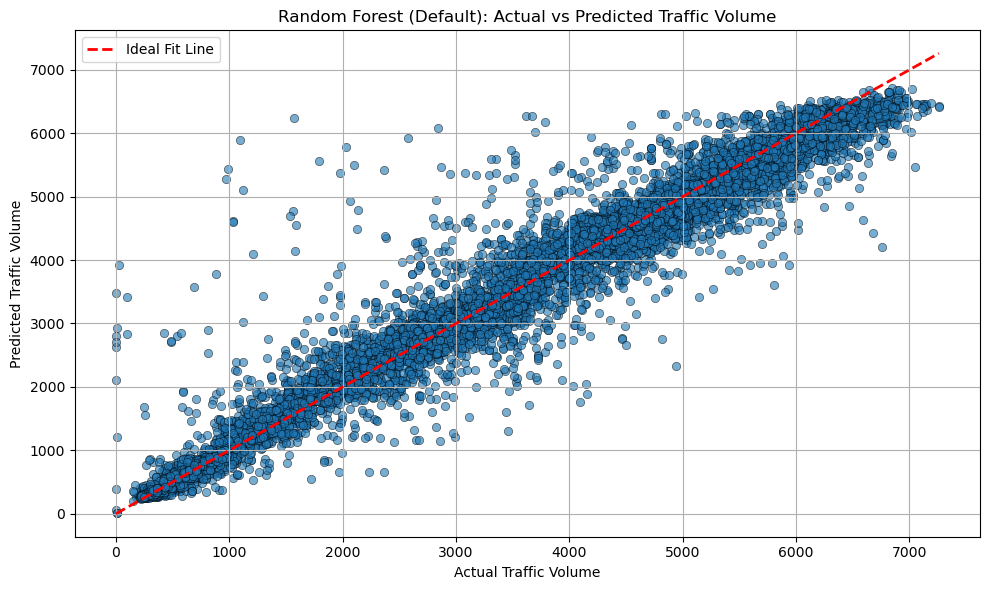

In [235]:
# Generate Predictions for the Test Set
best_model_predictions = selected_model.predict(xtest)

# Plot Actual vs Predicted for the Best Model
plot_actual_vs_predicted(ytest, best_model_predictions, model_name=best_model_name)

In [249]:
# Feature Importance for Random Forest
plot_feature_importance(selected_model, xtrain.columns)


Feature Importance:


,Feature,Importance
9,hour,0.838925
8,weekday,0.108048
0,temp,0.015436
7,day,0.013157
6,month,0.008475
5,year,0.004336
10,rush_hour,0.002763
3,weather_main_indexed,0.002448
4,weather_description_indexed,0.002250
2,clouds_all,0.002173


In [237]:
# Single Prediction
single_prediction(selected_model, X, 
                  temp=282.12, rain_1h=0, clouds_all=90, 
                  year=2018, month=9, day=30, hour=23, 
                  weather_main_indexed = 0, holiday_indexed = 0 , weather_description_indexed = 2)

Input Features for Prediction:


,temp,rain_1h,clouds_all,weather_main_indexed,weather_description_indexed,year,month,day,weekday,hour,rush_hour
0,282.12,0,90,0,2,2018,9,30,0,23,0


Predicted Traffic Volume: 1040


In [247]:
# Date Range Prediction
output_predictions = date_range_prediction(selected_model, X, start_date="2018-10-01 00:00", end_date="2018-10-07 23:00")


Generated Prediction Data:
2018-10-01 00:00:00: 609
2018-10-01 01:00:00: 367
2018-10-01 02:00:00: 261
2018-10-01 03:00:00: 357
2018-10-01 04:00:00: 898
2018-10-01 05:00:00: 2533
2018-10-01 06:00:00: 5714
2018-10-01 07:00:00: 6212
2018-10-01 08:00:00: 5497
2018-10-01 09:00:00: 5304
2018-10-01 10:00:00: 4598
2018-10-01 11:00:00: 4822
2018-10-01 12:00:00: 4846
2018-10-01 13:00:00: 4846
2018-10-01 14:00:00: 5155
2018-10-01 15:00:00: 5689
2018-10-01 16:00:00: 6083
2018-10-01 17:00:00: 5852
2018-10-01 18:00:00: 4672
2018-10-01 19:00:00: 3561
2018-10-01 20:00:00: 3095
2018-10-01 21:00:00: 3158
2018-10-01 22:00:00: 2324
2018-10-01 23:00:00: 1512
2018-10-02 00:00:00: 705
2018-10-02 01:00:00: 386
2018-10-02 02:00:00: 276
2018-10-02 03:00:00: 370
2018-10-02 04:00:00: 897
2018-10-02 05:00:00: 2518
2018-10-02 06:00:00: 5700
2018-10-02 07:00:00: 6212
2018-10-02 08:00:00: 5497
2018-10-02 09:00:00: 5329
2018-10-02 10:00:00: 4549
2018-10-02 11:00:00: 4787
2018-10-02 12:00:00: 4846
2018-10-02 13:00:00:

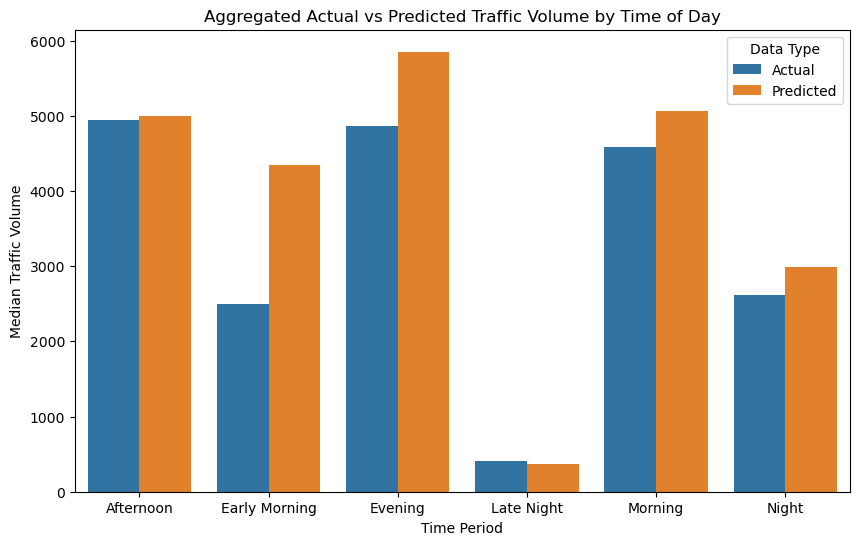

In [289]:
# Aggregate actual and predicted data by 'day_time'
def aggregate_data(actual_df, predicted_df):
    actual_agg = actual_df.groupby('day_time')['traffic_volume'].median().reset_index()
    actual_agg['type'] = 'Actual'
    
    predicted_agg = predicted_df.groupby('day_time')['traffic_volume'].median().reset_index()
    predicted_agg = predicted_agg.rename(columns={"traffic_volume": "traffic_volume"})
    predicted_agg['type'] = 'Predicted'
    
    # Combine both aggregated data
    combined_agg = pd.concat([actual_agg, predicted_agg])
    return combined_agg

# Aggregate data
aggregated_df = aggregate_data(df_traffic_features, output_predictions)

# Plot aggregated data
plt.figure(figsize=(10, 6))
sns.barplot(x='day_time', y='traffic_volume', hue='type', data=aggregated_df)
plt.title('Aggregated Actual vs Predicted Traffic Volume by Time of Day')
plt.ylabel('Median Traffic Volume')
plt.xlabel('Time Period')
plt.legend(title="Data Type")
plt.show()
